# SETUP

In [0]:
# import mlflow and autolog machine learning runs

import mlflow
mlflow.pyspark.ml.autolog()

# Loading Data and Exploratory Analysis

In [0]:
from pyspark.sql.types import *

# Define schema for the DataFrame
schema = StructType([
    StructField("_c0", IntegerType(), True),  # Assuming it's the user ID
    StructField("_c1", StringType(), True),   # Assuming it's the game name
    StructField("_c2", StringType(), True),   # Assuming it's the behavior ('purchase' or 'play')
    StructField("_c3", DoubleType(), True),   # Assuming it's the hours played or purchased
])

# Load the DataFrame with specified schema
steam_df = spark.read.csv("/FileStore/tables/steam_200k.csv", schema=schema)

In [0]:
steam_df.show()

+---------+--------------------+--------+-----+
|      _c0|                 _c1|     _c2|  _c3|
+---------+--------------------+--------+-----+
|151603712|The Elder Scrolls...|purchase|  1.0|
|151603712|The Elder Scrolls...|    play|273.0|
|151603712|           Fallout 4|purchase|  1.0|
|151603712|           Fallout 4|    play| 87.0|
|151603712|               Spore|purchase|  1.0|
|151603712|               Spore|    play| 14.9|
|151603712|   Fallout New Vegas|purchase|  1.0|
|151603712|   Fallout New Vegas|    play| 12.1|
|151603712|       Left 4 Dead 2|purchase|  1.0|
|151603712|       Left 4 Dead 2|    play|  8.9|
|151603712|            HuniePop|purchase|  1.0|
|151603712|            HuniePop|    play|  8.5|
|151603712|       Path of Exile|purchase|  1.0|
|151603712|       Path of Exile|    play|  8.1|
|151603712|         Poly Bridge|purchase|  1.0|
|151603712|         Poly Bridge|    play|  7.5|
|151603712|         Left 4 Dead|purchase|  1.0|
|151603712|         Left 4 Dead|    play

In [0]:
renaming_mapping = {
    "_c0": "UserId","_c1": "Game_Name","_c2": "Behavior","_c3": "Value"
}

steam_200kDF = steam_df
for old_name, new_name in renaming_mapping.items():
    steam_200kDF = steam_200kDF.withColumnRenamed(old_name, new_name)

# Displaying the renamed DataFrame
steam_200kDF.show(5)

+---------+--------------------+--------+-----+
|   UserId|           Game_Name|Behavior|Value|
+---------+--------------------+--------+-----+
|151603712|The Elder Scrolls...|purchase|  1.0|
|151603712|The Elder Scrolls...|    play|273.0|
|151603712|           Fallout 4|purchase|  1.0|
|151603712|           Fallout 4|    play| 87.0|
|151603712|               Spore|purchase|  1.0|
+---------+--------------------+--------+-----+
only showing top 5 rows



In [0]:
# Summary statistics
steam_200kDF.describe().show()

+-------+-------------------+----------------+--------+------------------+
|summary|             UserId|       Game_Name|Behavior|             Value|
+-------+-------------------+----------------+--------+------------------+
|  count|             200000|          200000|  200000|            200000|
|   mean|  1.0365586594664E8|           140.0|    NULL|17.874383999999914|
| stddev|7.208073512913968E7|             0.0|    NULL|138.05695165086792|
|    min|               5250|     007 Legends|    play|               0.1|
|    max|          309903146|theHunter Primal|purchase|           11754.0|
+-------+-------------------+----------------+--------+------------------+



In [0]:
# Check the first few rows of the DataFrame
steam_200kDF.show()

+---------+--------------------+--------+-----+
|   UserId|           Game_Name|Behavior|Value|
+---------+--------------------+--------+-----+
|151603712|The Elder Scrolls...|purchase|  1.0|
|151603712|The Elder Scrolls...|    play|273.0|
|151603712|           Fallout 4|purchase|  1.0|
|151603712|           Fallout 4|    play| 87.0|
|151603712|               Spore|purchase|  1.0|
|151603712|               Spore|    play| 14.9|
|151603712|   Fallout New Vegas|purchase|  1.0|
|151603712|   Fallout New Vegas|    play| 12.1|
|151603712|       Left 4 Dead 2|purchase|  1.0|
|151603712|       Left 4 Dead 2|    play|  8.9|
|151603712|            HuniePop|purchase|  1.0|
|151603712|            HuniePop|    play|  8.5|
|151603712|       Path of Exile|purchase|  1.0|
|151603712|       Path of Exile|    play|  8.1|
|151603712|         Poly Bridge|purchase|  1.0|
|151603712|         Poly Bridge|    play|  7.5|
|151603712|         Left 4 Dead|purchase|  1.0|
|151603712|         Left 4 Dead|    play

In [0]:
# Count the number of unique users and games
num_users = steam_200kDF.select('userId').distinct().count()
num_games = steam_200kDF.select('game_name').distinct().count()
print("Number of unique users:", num_users)
print("Number of unique games:", num_games)

Number of unique users: 12393
Number of unique games: 5155


In [0]:
# Number of Behavior records with the details
Behavior = steam_200kDF.groupBy('behavior').count()
Behavior.show()

+--------+------+
|behavior| count|
+--------+------+
|purchase|129511|
|    play| 70489|
+--------+------+



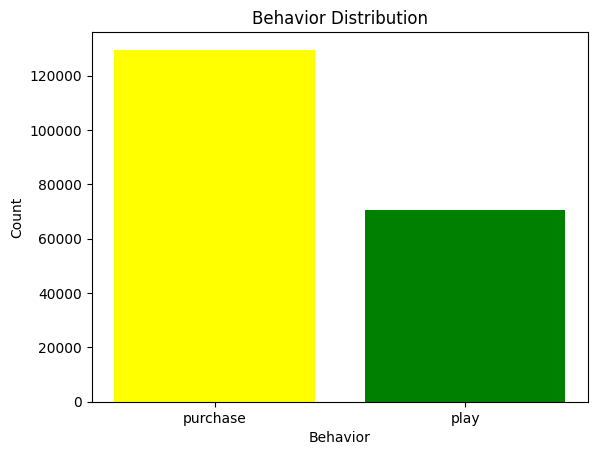

In [0]:
import matplotlib.pyplot as plt

# Get member behavior counts
steam_counts = steam_200kDF.groupBy('behavior').count().toPandas()

# Define colors for the bars
colors = ['yellow', 'green']

# Create a bar chart of the counts
plt.bar(steam_counts['behavior'], steam_counts['count'], color=colors)

# Set the chart title and axis labels
plt.title('Behavior Distribution')
plt.xlabel('Behavior')
plt.ylabel('Count')

# Show the chart
plt.show()


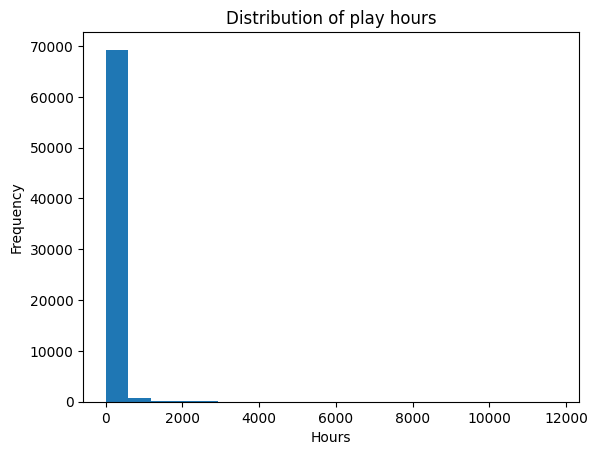

In [0]:
# Visualize distribution of play hours
import matplotlib.pyplot as plt

play_hours = steam_200kDF.filter(steam_200kDF.Behavior == 'play').select('value').rdd.flatMap(lambda x: x).collect()
plt.hist(play_hours, bins=20)
plt.title("Distribution of play hours")
plt.xlabel("Hours")
plt.ylabel("Frequency")
plt.show()

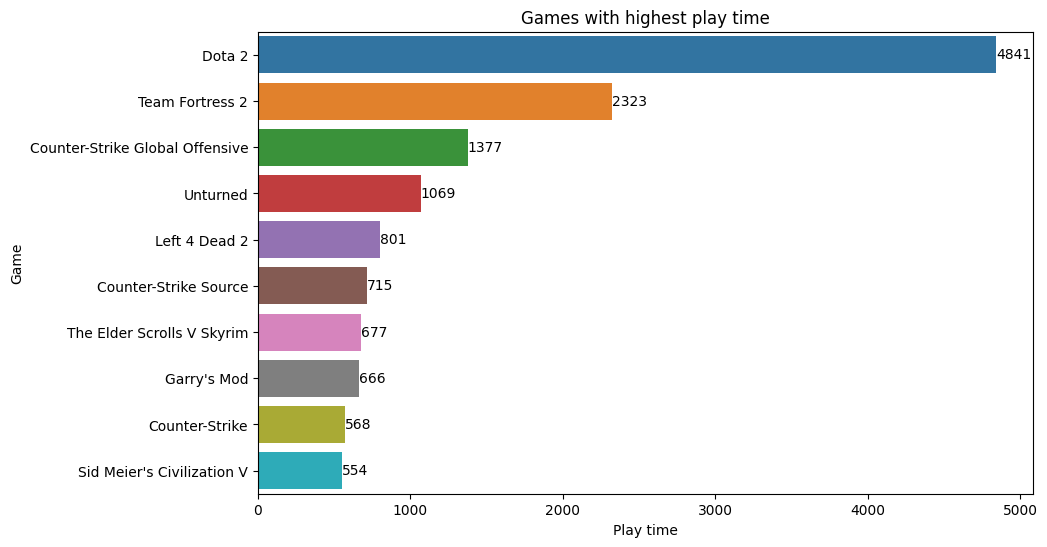

In [0]:
import seaborn as sns

# Analyze the distribution of play time counts
play_time_counts = steam_200kDF.filter(steam_200kDF['Behavior'] == 'play').groupBy('game_name').count().orderBy('count', ascending=False).limit(10).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='game_name', data=play_time_counts) 

# Add annotations to each bar
for index, value in enumerate(play_time_counts['count']):
    plt.text(value, index, str(value), va='center')

plt.title('Games with highest play time')
plt.xlabel('Play time')
plt.ylabel('Game')
plt.show()

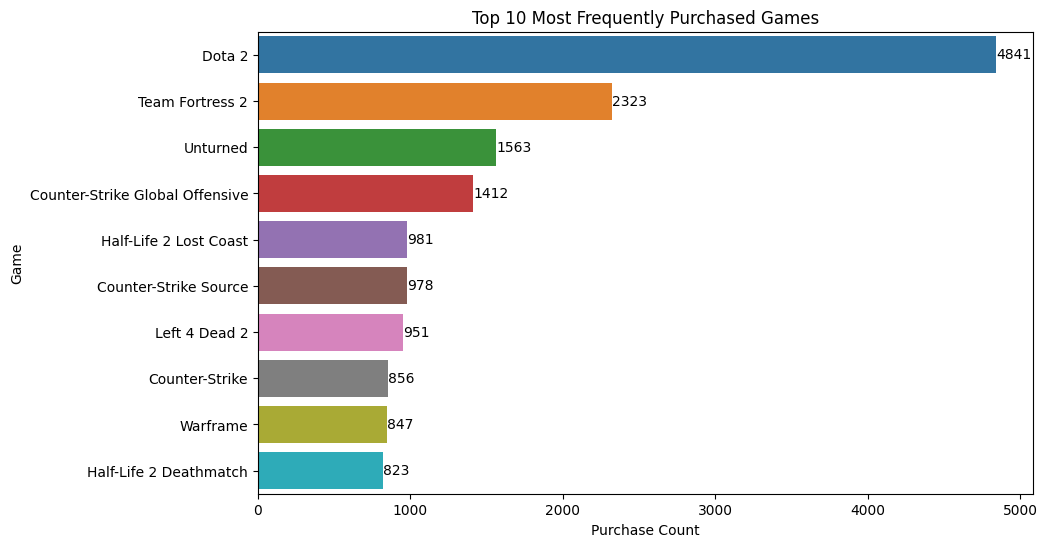

In [0]:
import seaborn as sns
# Analyze the distribution of purchase counts
purchase_counts = steam_200kDF.filter(steam_200kDF['Behavior'] == 'purchase').groupBy('game_name').count().orderBy('count', ascending=False).limit(10).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='game_name', data=purchase_counts)

# Add annotations to each bar
for index, value in enumerate(purchase_counts['count']):
    plt.text(value, index, str(value), va='center')

plt.title('Top 10 Most Frequently Purchased Games')
plt.xlabel('Purchase Count')
plt.ylabel('Game')
plt.show()

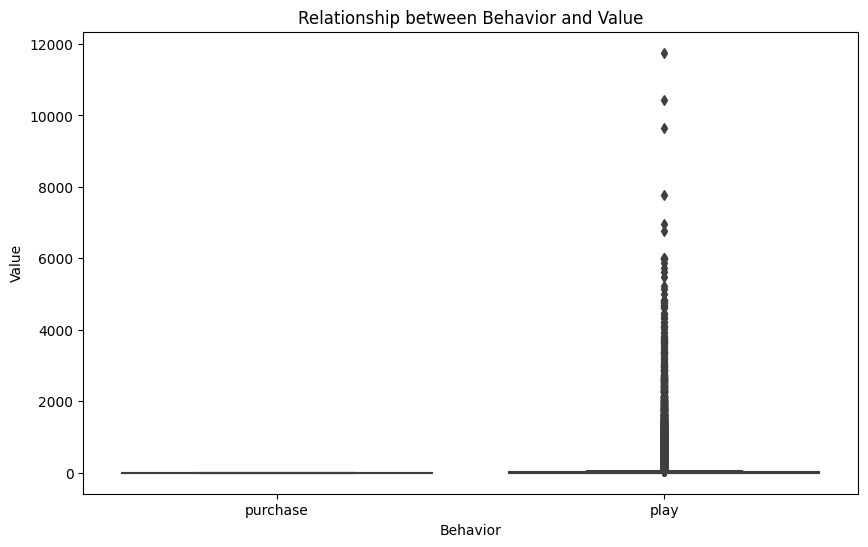

In [0]:
# Explore the relationship between behavior and value
plt.figure(figsize=(10, 6))
sns.boxplot(x='Behavior', y='Value', data=steam_200kDF.toPandas())
plt.title('Relationship between Behavior and Value')
plt.xlabel('Behavior')
plt.ylabel('Value')
plt.show()

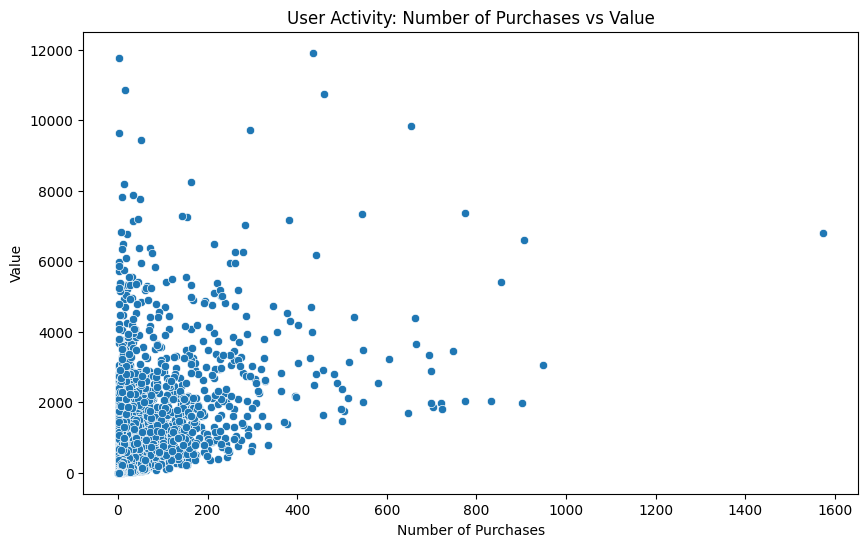

In [0]:
# Visualize the distribution of user activity
user_activity = steam_200kDF.groupBy('userId').agg({'behavior': 'count', 'value': 'sum'}).toPandas()
plt.figure(figsize=(10, 6))
sns.scatterplot(x='count(behavior)', y='sum(value)', data=user_activity)
plt.title('User Activity: Number of Purchases vs Value')
plt.xlabel('Number of Purchases')
plt.ylabel('Value')
plt.show()

In [0]:
# Dstinct records of Game name with the details
game_counts = steam_200kDF.groupBy('Game_Name').count()
sorted_game_counts = game_counts.orderBy('count', ascending=False)
sorted_game_counts.show()

+--------------------+-----+
|           Game_Name|count|
+--------------------+-----+
|              Dota 2| 9682|
|     Team Fortress 2| 4646|
|Counter-Strike Gl...| 2789|
|            Unturned| 2632|
|       Left 4 Dead 2| 1752|
|Counter-Strike So...| 1693|
|      Counter-Strike| 1424|
|         Garry's Mod| 1397|
|The Elder Scrolls...| 1394|
|            Warframe| 1271|
|Half-Life 2 Lost ...| 1158|
|Sid Meier's Civil...| 1150|
|           Robocraft| 1096|
|Half-Life 2 Death...| 1021|
|              Portal| 1005|
|            Portal 2|  997|
|         Half-Life 2|  995|
|   Heroes & Generals|  993|
|            Terraria|  956|
|Counter-Strike Co...|  904|
+--------------------+-----+
only showing top 20 rows



#Data Preparation and Pre-Processing

In [0]:
# Generating the GameId
from pyspark.ml.feature import StringIndexer

GameId = StringIndexer(inputCol="Game_Name", outputCol="GameId")

Game_df = GameId.fit(steam_200kDF).transform(steam_200kDF)

Game_df.show()

2024/04/27 08:38:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'eef681e539f9499fbef7eda033a36b7f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


+---------+--------------------+--------+-----+------+
|   UserId|           Game_Name|Behavior|Value|GameId|
+---------+--------------------+--------+-----+------+
|151603712|The Elder Scrolls...|purchase|  1.0|   8.0|
|151603712|The Elder Scrolls...|    play|273.0|   8.0|
|151603712|           Fallout 4|purchase|  1.0| 100.0|
|151603712|           Fallout 4|    play| 87.0| 100.0|
|151603712|               Spore|purchase|  1.0| 332.0|
|151603712|               Spore|    play| 14.9| 332.0|
|151603712|   Fallout New Vegas|purchase|  1.0|  29.0|
|151603712|   Fallout New Vegas|    play| 12.1|  29.0|
|151603712|       Left 4 Dead 2|purchase|  1.0|   4.0|
|151603712|       Left 4 Dead 2|    play|  8.9|   4.0|
|151603712|            HuniePop|purchase|  1.0| 867.0|
|151603712|            HuniePop|    play|  8.5| 867.0|
|151603712|       Path of Exile|purchase|  1.0|  39.0|
|151603712|       Path of Exile|    play|  8.1|  39.0|
|151603712|         Poly Bridge|purchase|  1.0|1347.0|
|151603712

In [0]:
#  DataFrame for 'purchase' behavior
purchase_df = Game_df[Game_df['Behavior'] == 'purchase']

In [0]:
#  DataFrame for 'play' behavior
play_df = Game_df[Game_df['Behavior'] == 'play']

In [0]:
purchase_df.show()

+---------+--------------------+--------+-----+------+
|   UserId|           Game_Name|Behavior|Value|GameId|
+---------+--------------------+--------+-----+------+
|151603712|The Elder Scrolls...|purchase|  1.0|   8.0|
|151603712|           Fallout 4|purchase|  1.0| 100.0|
|151603712|               Spore|purchase|  1.0| 332.0|
|151603712|   Fallout New Vegas|purchase|  1.0|  29.0|
|151603712|       Left 4 Dead 2|purchase|  1.0|   4.0|
|151603712|            HuniePop|purchase|  1.0| 867.0|
|151603712|       Path of Exile|purchase|  1.0|  39.0|
|151603712|         Poly Bridge|purchase|  1.0|1347.0|
|151603712|         Left 4 Dead|purchase|  1.0|  49.0|
|151603712|     Team Fortress 2|purchase|  1.0|   1.0|
|151603712|         Tomb Raider|purchase|  1.0|  55.0|
|151603712|     The Banner Saga|purchase|  1.0| 604.0|
|151603712|Dead Island Epidemic|purchase|  1.0|  51.0|
|151603712|   BioShock Infinite|purchase|  1.0|  42.0|
|151603712|Dragon Age Origin...|purchase|  1.0| 301.0|
|151603712

# Model training, Evaluation and Hyperparameter 

In [0]:
# Train collaborative filtering recommender system
# Split the data into training and test sets
(trainingDF, testDF) = purchase_df.randomSplit([0.8, 0.2], seed= 100)

In [0]:
# Convert the DataFrame into the format required by the collaborative filtering algorithm(Training the Model)
from pyspark.ml.recommendation import ALS

als = ALS(maxIter=5, regParam=0.01, userCol="UserId", itemCol="GameId", ratingCol="Value", coldStartStrategy="drop")

# Fit the ALS model on the training data
model = als.fit(trainingDF)

2024/04/27 08:38:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6bc9ff8abc4b42979d46ed34c50b8e59', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/04/27 08:38:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Valu

In [0]:
# Make predictions on the test data

predictions = model.transform(testDF)

predictions.show()

+------+--------------------+--------+-----+------+----------+
|UserId|           Game_Name|Behavior|Value|GameId|prediction|
+------+--------------------+--------+-----+------+----------+
|  5250|Counter-Strike So...|purchase|  1.0|     5| 0.9743345|
|  5250|Half-Life 2 Death...|purchase|  1.0|    13|0.97621745|
|  5250|Half-Life Blue Shift|purchase|  1.0|    74|0.98232716|
|  5250|Team Fortress Cla...|purchase|  1.0|    79| 0.9821147|
| 76767|Arma 2 Operation ...|purchase|  1.0|   129| 0.9877363|
| 76767|Call of Duty Mode...|purchase|  1.0|    25|0.95887834|
| 76767|      Counter-Strike|purchase|  1.0|     6| 0.9056422|
| 76767|Counter-Strike Gl...|purchase|  1.0|     2| 0.9271606|
| 76767|       Day of Defeat|purchase|  1.0|    28|0.91442585|
| 76767|  Deathmatch Classic|purchase|  1.0|    34| 0.9136086|
| 76767|Half-Life Blue Shift|purchase|  1.0|    74|0.94661915|
| 76767|Half-Life Opposin...|purchase|  1.0|    75| 0.9456815|
| 76767|             Thief 2|purchase|  1.0|   995| 1.0

In [0]:
# Evaluate the model by computing the RMSE
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="Value", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

Root Mean Squared Error (RMSE) on test data = 0.06992020210977688


In [0]:
from pyspark.sql.functions import explode, col

# Generate top recommendations for each user
userRecs = model.recommendForAllUsers(5)

# Show recommendations for a specific user (replace UserId with any user ID)
UserId = 53875128
user_recommendations = userRecs.select("UserId", explode("recommendations").alias("recommendation")) \
                               .filter(userRecs.UserId == UserId) \
                               .select("UserId", "recommendation.GameId", "recommendation.rating")

# Join with Game names to get the Game names
user_recommendations_with_names = user_recommendations.join(purchase_df.select("GameId", "Game_Name").distinct(),
                                                            user_recommendations["GameId"] == purchase_df["GameId"],
                                                            "left") \
                                                      .select(user_recommendations["UserId"],
                                                              purchase_df["Game_Name"],
                                                              user_recommendations["rating"])

# Show recommendations in a tabular form
user_recommendations_with_names.show(truncate=False)

+--------+------------------------------+---------+
|UserId  |Game_Name                     |rating   |
+--------+------------------------------+---------+
|53875128|IL-2 Sturmovik Cliffs of Dover|1.1497655|
|53875128|The Amazing Spider-Man        |1.1288923|
|53875128|Steel Ocean                   |1.1206661|
|53875128|Terrain Test                  |1.1191045|
|53875128|RACE Caterham Expansion       |1.1186852|
+--------+------------------------------+---------+



In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

 # training models with different hyperparameters(Hyper parameter tunning)

# Define the parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [5, 10, 15]) \
    .addGrid(als.regParam, [0.01, 0.1, 0.5]) \
    .build()

# Define evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Value", predictionCol="prediction")

# Define cross-validator
cross_validator = CrossValidator(estimator=als,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=5)  # Use 5 folds for cross-validation

# Perform cross-validation and hyperparameter tuning
cv_model = cross_validator.fit(trainingDF)

# Get the best model from cross-validation
best_model = cv_model.bestModel

# Make predictions on the test data using the best model
predictions = best_model.transform(testDF)

# Evaluate the performance of the best model
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data after hyperparameter tuning:", rmse)

# Print the best hyperparameters found
print("Best Rank:", best_model.rank)
print("Best Regularization Parameter:", best_model._java_obj.parent().getRegParam())

2024/04/27 08:40:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c2f0710cad5e465dbdaabfbcf00eff1d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/04/27 08:53:11 WARNING mlflow.pyspark.ml: Model CrossValidatorModel_ba78876b400e will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


Root Mean Squared Error (RMSE) on test data after hyperparameter tuning: 0.07739710217212052
Best Rank: 5
Best Regularization Parameter: 0.01
